In [1]:
#   Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import torch
import timm
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torch import nn
from torchvision import transforms, utils, datasets, models
from torchvision.models import ResNet50_Weights
from torchvision.io import read_image
from PIL import Image
import scipy.io as sio
from ignite.metrics import MultiLabelConfusionMatrix
from sklearn.metrics import multilabel_confusion_matrix
import math
import wandb
import gc

In [2]:
#   Variables
device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

In [3]:
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project"
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jayamsutariya26 (unrmpl). Use `wandb login --relogin` to force relogin


In [3]:
# Create the new model
class CaricatureClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        #self.model = MultilabelClassifier()
        self.model = models.resnet50(pretrained=True)
        self.model_wo_fc = nn.Sequential(*list(self.model.children())[:-1])

        self.cheekbones = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )
        self.cheeks = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )
        self.chin = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )
        self.ears = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )
        self.eyebrows = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )
        self.eyelids = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )
        self.eyes = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )
        self.facial_hair = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )
        self.forehead = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )
        self.hair = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )
        self.head = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )
        self.lips = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )
        self.mouth = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )
        self.neck = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )
        self.nose = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )
        self.skin = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )
        self.teeth = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )
        self.upper_lip = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.model_wo_fc(x)
        x = torch.flatten(x, 1)

        return [
            self.cheekbones(x),
            self.cheeks(x),
            self.chin(x),
            self.ears(x),
            self.eyebrows(x),
            self.eyelids(x),
            self.eyes(x),
            self.facial_hair(x),
            self.forehead(x),
            self.hair(x),
            self.head(x),
            self.lips(x),
            self.mouth(x),
            self.neck(x),
            self.nose(x),
            self.skin(x),
            self.teeth(x),
            self.upper_lip(x)
        ]

In [26]:
#BAGS OF IMAGES
import cv2
root_dir = 'C:\\Users\\Jayam\\OneDrive\\Desktop\\School Work\\Grad school\\Research Work\\for Jay\\ourcar\\'
labels = np.loadtxt('binary_labels.txt', dtype=str)
bags = []
for idx, label in enumerate(labels):
    car_label = label[0] + "_caricature"
    img_person = os.path.join(root_dir, car_label)
    person_image = []
    for filename in os.listdir(img_person):
        img = cv2.imread(os.path.join(img_person, filename))
        person_image.append(img)
    bag = label, person_image
    bags.append(bag)
    
del root_dir, labels, bags

In [27]:
#Display Image
cv2.imshow('image', bags[0][1][0])
cv2.waitKey(0)

NameError: name 'bags' is not defined

In [4]:
#   Create Dataloader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

class CaricatureDataset(Dataset):
    def __init__(self, labels_file, root_dir, transform=None):
        self.labels = pd.read_csv(labels_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # This will read the first 5 images per person, this can probably be tweaked to include all images
        class_index = math.floor(idx/5)
        image_num = idx%5
        self_car = self.labels.iloc[class_index, 0].strip() + "_caricature"
        img_person = os.path.join(self.root_dir, self_car)
        labels = self.labels.iloc[class_index, 1].replace('[', '').replace(']', '').split('.')[:-1]
        labels = np.array([int(label) for label in labels])
        img = read_image(os.path.join(img_person, os.listdir(img_person)[image_num]))
        if img.shape[0] == 1:
            img = np.repeat(img, 3, axis=0)
        sample = img, labels
        return sample

In [5]:
#   Load the data
dataset = CaricatureDataset(labels_file='binary_labels.txt', root_dir='/home/jsutariya/Desktop/Project/ourcar/', transform=transform)
#   Split the data into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
#   Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [6]:
print('Training set has {} instances'.format(len(train_dataset)))
print('Validation set has {} instances'.format(len(test_dataset)))

Training set has 162 instances
Validation set has 41 instances


In [13]:
def training(model, device, lr, epochs, train_loader):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion  = nn.BCELoss()
    accurate_predictions = 0
    total_predictions = 0
    model.train()
    all_true_labels = np.array([])
    all_pred_labels = np.array([])
    for epoch in range(epochs):
        overacc = 0
        overpred = 0
        runloss = 0
        lastloss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            data = data.float()
            target = target.float()
            optimizer.zero_grad()
            output = model(data)
            output = torch.stack(output, dim=1)
            predictions = np.round(output.detach().cpu().numpy()).flatten()
            labels = target.detach().cpu().numpy().flatten()
            all_true_labels = np.concatenate((all_true_labels, labels))
            all_pred_labels = np.concatenate((all_pred_labels, predictions))
            output = output.squeeze(2)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            for index, prediction in enumerate(predictions):
                if prediction == labels[index]:
                    accurate_predictions += 1
                    overacc += 1
                total_predictions += 1
                overpred += 1
            #print('Predictions for ', str(batch_idx), ': ', predictions)
            #print('Labels for ', str(batch_idx), ': ', labels)
            runloss += loss.item()
            if batch_idx % 10 == 0:
                lastloss = runloss / 10
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}'.format(
                    epoch+1, int((batch_idx+1)/len(train_loader)*len(train_loader.dataset)), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), runloss, accurate_predictions/total_predictions))
                accurate_predictions = 0
                total_predictions = 0
                runloss = 0
        #wandb.log({"acc": overacc/overpred, "loss": lastloss})
        
    torch.save(model.state_dict(), 'model.pt')

def testing(model, device, test_loader):
    criterion  = nn.BCELoss()
    running_vloss = 0.0
    
    model.eval()
    correct = 0
    all_true_labels = np.array([])
    all_predictions = np.array([])
    all_true_labels_itemized = np.zeros([1,18])
    all_predictions_itemized = np.zeros([1,18])
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            print("IIIIIIIIIIIIIIIIIIIII", i)
            data, target = data.to(device).float(), target.to(device).float()
            output = model(data)
            outputs = torch.stack(output, dim=1)
            predictions = np.round(outputs.detach().cpu().numpy())
            print("Preictionssss", predictions)
            labels = target.detach().cpu().numpy()
            all_true_labels = np.append(all_true_labels, labels)
            all_predictions = np.append(all_predictions, predictions)
            predictions = predictions.transpose()
            print("Predictionsss transposed", predictions)
            all_true_labels_itemized = np.concatenate((all_true_labels_itemized, labels), axis=0)
            print("Predictions[0] T", predictions[0].T)
            all_predictions_itemized = np.concatenate((all_predictions_itemized, predictions[0].T), axis=0)
            print("Concatenated matrix", all_predictions_itemized)
            outputs = outputs.squeeze(2)
            vloss = criterion(outputs, target)
            running_vloss += vloss
    avg_vloss = running_vloss / (i + 1)        
    for index, prediction in enumerate(all_predictions):
        if prediction == all_true_labels[index]:
            correct += 1
    print('Accuracy: ', correct/len(all_predictions))
    print('Loss: ', avg_vloss)
    print('Confusion Matrix: ', multilabel_confusion_matrix(all_true_labels, all_predictions))
    return all_true_labels_itemized, all_predictions_itemized

In [9]:
model = CaricatureClassifier().to(device)
trainmodel = training(model, device, 0.001, 1, train_loader)

Train Epoch: 1 [3/162 (0%)]	Loss: 0.728420	Accuracy: 0.44
Train Epoch: 1 [43/162 (24%)]	Loss: 6.884956	Accuracy: 0.53
Train Epoch: 1 [82/162 (49%)]	Loss: 5.860824	Accuracy: 0.73
Train Epoch: 1 [122/162 (73%)]	Loss: 5.187334	Accuracy: 0.76
Train Epoch: 1 [162/162 (98%)]	Loss: 5.162217	Accuracy: 0.75


In [14]:
labels, predictions = testing(model, device, test_loader)
#wandb.finish()

IIIIIIIIIIIIIIIIIIIII 0
Preictionssss [[[0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]]]
Predictionsss transposed [[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 0. 0.]
  [1. 1. 1. 1.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [1. 1. 1. 1.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [1. 1. 1. 1.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
Predictions[0] T [[0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0.

In [15]:
# Tranpose the matrices to isolate each feature
transposed_labels = labels.transpose()
transposed_predictions = predictions.transpose()

[[0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
  0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0.
  0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
  1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0.
  0. 0. 0

In [12]:
accuracies = np.empty(18)
for index, feature in enumerate(transposed_labels):
    correct = 0
    for index2, value in enumerate(feature):
        if value == transposed_predictions[index][index2]:
            correct += 1
    accuracies[index] = correct/len(feature)

In [13]:
print(accuracies)
multilabel_confusion_matrix(labels, predictions)

[0.69047619 0.73809524 0.64285714 0.78571429 0.64285714 0.97619048
 0.80952381 0.85714286 0.83333333 0.78571429 0.73809524 0.64285714
 0.78571429 1.         0.88095238 0.92857143 0.88095238 0.97619048]


array([[[19,  6],
        [ 7, 10]],

       [[19,  7],
        [ 4, 12]],

       [[19,  3],
        [12,  8]],

       [[26,  7],
        [ 2,  7]],

       [[13,  8],
        [ 7, 14]],

       [[40,  0],
        [ 1,  1]],

       [[ 4,  4],
        [ 4, 30]],

       [[30,  2],
        [ 4,  6]],

       [[30,  2],
        [ 5,  5]],

       [[29,  5],
        [ 4,  4]],

       [[28,  3],
        [ 8,  3]],

       [[13,  9],
        [ 6, 14]],

       [[26,  1],
        [ 8,  7]],

       [[42,  0],
        [ 0,  0]],

       [[ 2,  5],
        [ 0, 35]],

       [[39,  0],
        [ 3,  0]],

       [[34,  0],
        [ 5,  3]],

       [[41,  0],
        [ 1,  0]]])

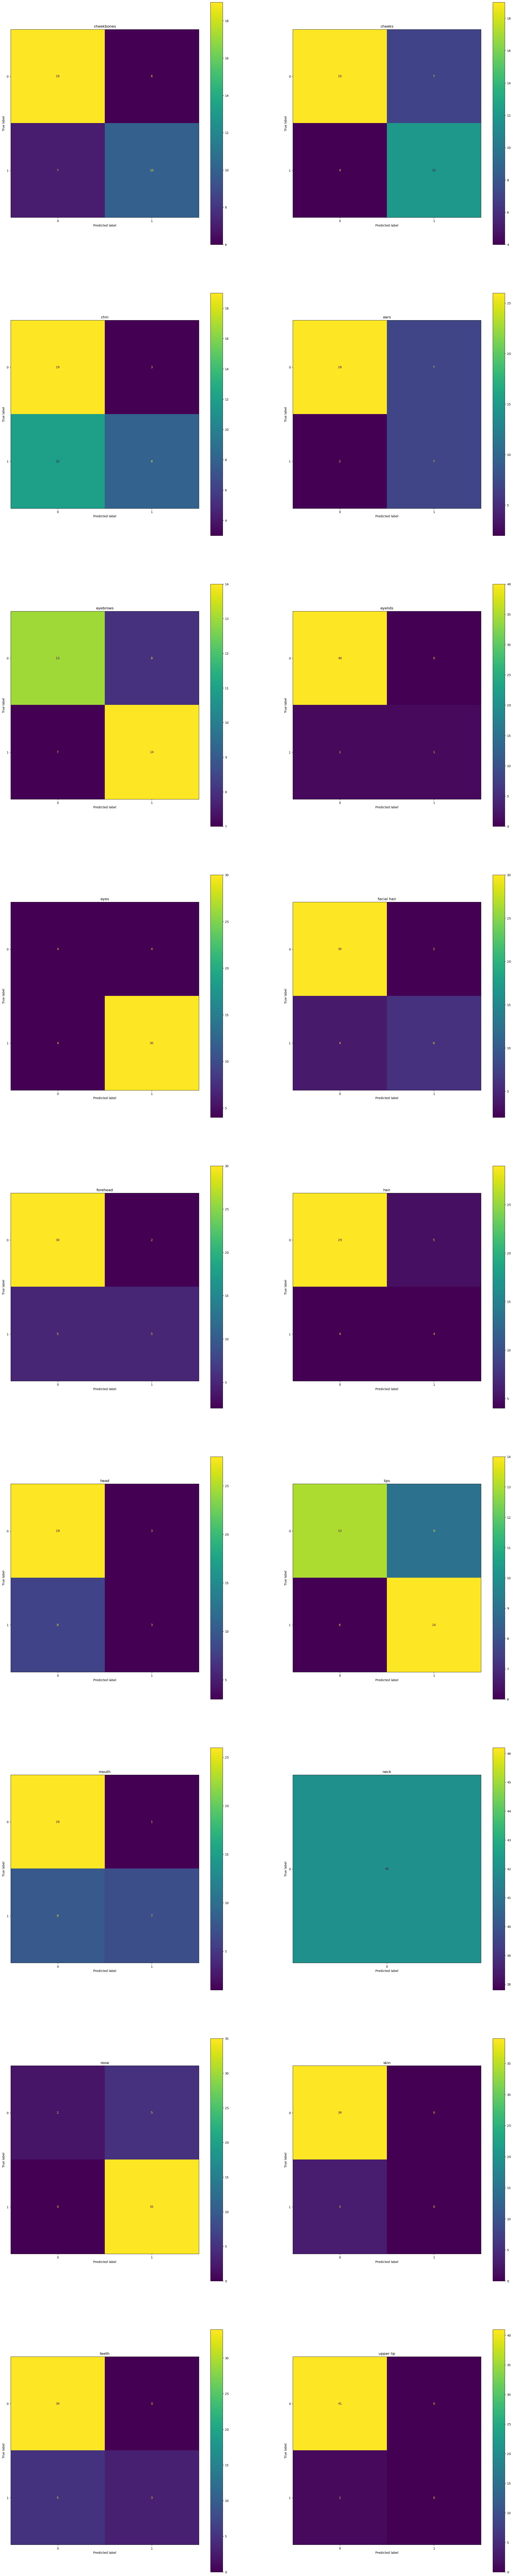

In [14]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

features = np.array([
    'cheekbones', 
    'cheeks', 
    'chin', 
    'ears', 
    'eyebrows', 
    'eyelids', 
    'eyes', 
    'facial hair', 
    'forehead', 
    'hair', 
    'head', 
    'lips', 
    'mouth', 
    'neck', 
    'nose', 
    'skin', 
    'teeth', 
    'upper lip'
])

fig, axes = plt.subplots(nrows=9, ncols=2, figsize=(30, 150))

for index, (feature, ax) in enumerate(zip(features, axes.flatten())):
    cm = confusion_matrix(transposed_labels[index],
                         transposed_predictions[index])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax)
    ax.title.set_text(feature)

plt.show()